In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import pickle
import torch
import random
import pandas as pd


In [2]:
#Set seeds to allow for reproducibility of the results
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
# cluster = LocalCUDACluster()
# client = Client(cluster)
# client

In [4]:
#For whole blood dataset
data = pd.read_csv("intersect_4DNFI18UHVRO.10kb.with_id.with_transcripts.erna_gene_filt.with_exp.txt", sep = "\t")

In [5]:
data

,transcript1,expression1,transcript2,expression2,dist,norm_contacts
0,ENSG00000272455,-0.028341,ENSR00000000202,-0.000818,140000,48
1,ENSG00000224051,-0.012343,ENSR00000000202,-0.000818,230000,32
2,ENSG00000224870,0.005104,ENSR00000000202,-0.000818,150000,58
3,ENSG00000197785,0.055437,ENSR00000000202,-0.000818,40000,121
4,ENSG00000272512,-0.025277,ENSR00000000202,-0.000818,560000,12
...,...,...,...,...,...,...
85625,ENSR00000144311,-0.147444,ENSG00000008735,-0.045636,26700000,1
85626,ENSR00000146851,0.470797,ENSG00000008735,-0.045636,7710000,1
85627,ENSR00000144050,-0.134191,ENSG00000008735,-0.045636,28870000,1
85628,ENSR00000146851,0.470797,ENSG00000100299,-0.279448,7720000,3


In [5]:
#Prepare training, validation, and test data
train = data[["expression1", "expression2", "dist", "norm_contacts"]]
train_features = train.copy()

##Log-normalize contact frequencies
#train_features["norm_contacts"] = np.log(train_features["norm_contacts"])

##Log1p-normalize genomic distances
#train_features["dist"] = np.log1p(train_features["dist"])

train_labels = train_features.pop("norm_contacts")
#train_features.pop("expression1")
#train_features.pop("expression2")
train_features.pop("dist")
train_labels

#train_labels = list(map(lambda x: x.replace('ad', '0'), train_labels))
#train_labels = list(map(lambda x: x.replace('scc', '1'), train_labels))

#train_labels = [int(x) for x in train_labels]
train_labels = np.array(train_labels)

train_labels

train_set_final, test_set_final, train_labels_final, test_labels_final = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)
#val_set_final, test_set_final, val_labels_final, test_labels_final = train_test_split(test_set_prelim, test_labels_prelim, test_size=0.5, random_state=42)

In [6]:
train_set_final = np.array(train_set_final)
train_set_final.shape

train_labels_final = np.array(train_labels_final)
train_labels_final.shape

(68504,)

In [31]:
# val_set_final = np.array(val_set_final)
# val_set_final.shape

# val_labels_final = np.array(val_labels_final)
# val_labels_final.shape

In [7]:
test_set_final = np.array(test_set_final)
test_set_final.shape

(17126, 2)

In [8]:
train_features = np.array(train_features)

In [9]:
# X = np.concatenate((train_set_final, val_set_final), axis=0)
# y = np.concatenate((train_labels_final, val_labels_final), axis=0)
X = train_set_final
y = train_labels_final

In [10]:
#Initialize a linear regression model and fit it to the training set
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [11]:
#Test the model using the test set
y_pred = model.predict(test_set_final)

In [12]:
#Calculare the predictive R2 of the model
r2 = r2_score(test_labels_final, y_pred)
print(f'R² Score: {r2:.5f}')

R² Score: 0.00084


The best polynomial degree is: 7
R² Score of the best model: 0.02


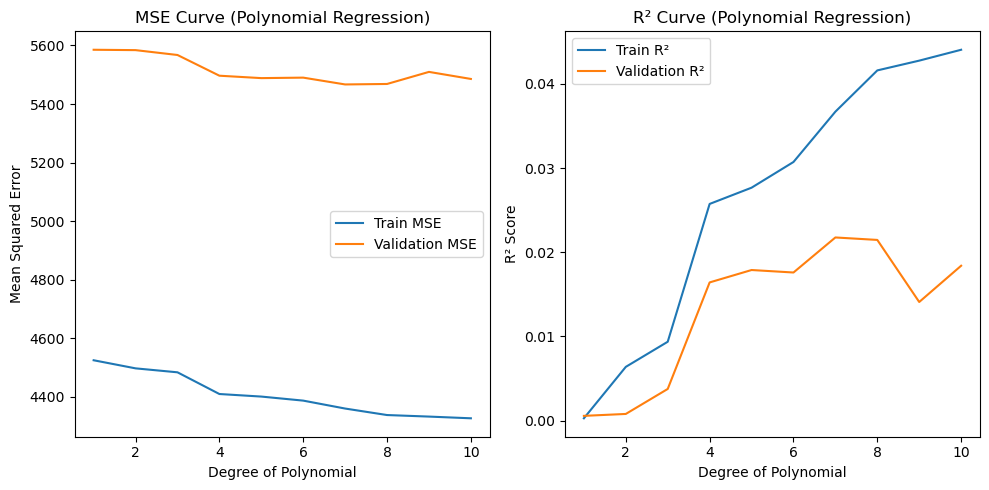

In [13]:
#Polynomial regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

train_errors = []
val_errors = []
val_r2_scores = []
train_r2_scores = []
degrees = range(1, 11)  # Trying polynomial degrees from 1 to 10

best_r2 = -np.inf
best_degree = 0
best_model = None

for degree in degrees:
    # Transform features into polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X_train)
    X_poly_val = poly.transform(X_val)
    
    # Train the model
    model = LinearRegression()
    model.fit(X_poly_train, y_train)
    
    # Predict on training and validation sets
    y_train_pred = model.predict(X_poly_train)
    y_val_pred = model.predict(X_poly_val)
    
    # Calculate and store the errors (mean squared error)
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    val_errors.append(mean_squared_error(y_val, y_val_pred))
    
    # Calculate and store R² scores on training and validation sets
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)
    
    # Track the best model (based on validation R² score)
    if val_r2 > best_r2:
        best_r2 = val_r2
        best_degree = degree
        best_model = model

# Plot the MSE curve
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(degrees, train_errors, label="Train MSE")
plt.plot(degrees, val_errors, label="Validation MSE")
plt.title('MSE Curve (Polynomial Regression)')
plt.xlabel('Degree of Polynomial')
plt.ylabel('Mean Squared Error')
plt.legend()

# Plot the R² curve
plt.subplot(1, 2, 2)
plt.plot(degrees, train_r2_scores, label="Train R²")
plt.plot(degrees, val_r2_scores, label="Validation R²")
plt.title('R² Curve (Polynomial Regression)')
plt.xlabel('Degree of Polynomial')
plt.ylabel('R² Score')
plt.legend()

plt.tight_layout()
#plt.show()
plt.savefig("whole_blood_polynomial_regression.png", dpi=300)

# Print the R² score of the best model
print(f'The best polynomial degree is: {best_degree}')
print(f'R² Score of the best model: {best_r2:.2f}')

The best number of trees is: 40
R² Score of the best model: 0.04


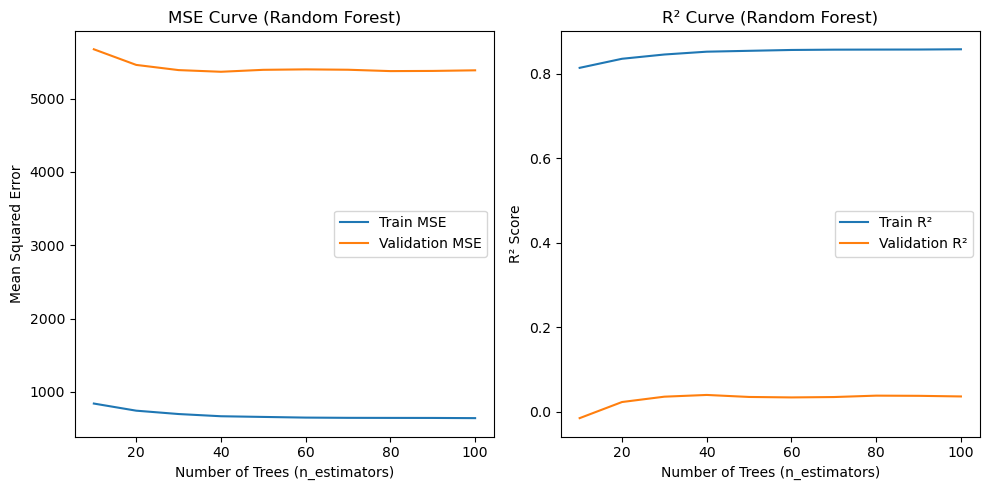

In [15]:
#Random forest regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

train_errors = []
val_errors = []
train_r2_scores = []
val_r2_scores = []
n_estimators_range = range(10, 110, 10)  # Varying number of trees from 10 to 100

best_r2 = -np.inf
best_n_estimators = 0
best_model = None

for n_estimators in n_estimators_range:
    # Initialize and train the model
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=0)
    model.fit(X_train, y_train.ravel())
    
    # Predict on training and validation sets
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Calculate and store the errors (mean squared error)
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    val_errors.append(mean_squared_error(y_val, y_val_pred))
    
    # Calculate and store R² scores on training and validation sets
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)
    
    # Track the best model (based on validation R² score)
    if val_r2 > best_r2:
        best_r2 = val_r2
        best_n_estimators = n_estimators
        best_model = model

# Plot the MSE curve
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(n_estimators_range, train_errors, label="Train MSE")
plt.plot(n_estimators_range, val_errors, label="Validation MSE")
plt.title('MSE Curve (Random Forest)')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Mean Squared Error')
plt.legend()

# Plot the R² curve
plt.subplot(1, 2, 2)
plt.plot(n_estimators_range, train_r2_scores, label="Train R²")
plt.plot(n_estimators_range, val_r2_scores, label="Validation R²")
plt.title('R² Curve (Random Forest)')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('R² Score')
plt.legend()

plt.tight_layout()
#plt.show()
plt.savefig("whole_blood_random_forest_regression.png", dpi=300)

# Print the R² score of the best model
print(f'The best number of trees is: {best_n_estimators}')
print(f'R² Score of the best model: {best_r2:.2f}')

The best epsilon is: 5.0
R² Score of the best model: -0.00


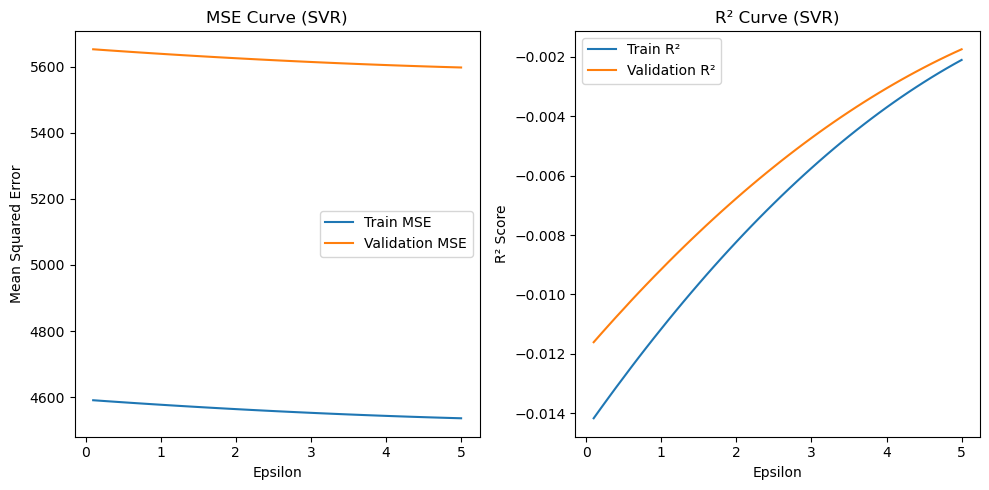

In [16]:
#Support vector regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

train_errors = []
val_errors = []
train_r2_scores = []
val_r2_scores = []
epsilon_range = np.arange(0.1, 5.1, 0.1)  # Varying epsilon from 0.1 to 5.0

best_r2 = -np.inf
best_epsilon = 0
best_model = None

for epsilon in epsilon_range:
    # Initialize and train the model
    model = SVR(kernel='rbf', C=1.0, epsilon=epsilon)
    model.fit(X_train, y_train.ravel())
    
    # Predict on training and validation sets
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Calculate and store the errors (mean squared error)
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    val_errors.append(mean_squared_error(y_val, y_val_pred))
    
    # Calculate and store R² scores on training and validation sets
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)
    
    # Track the best model (based on validation R² score)
    if val_r2 > best_r2:
        best_r2 = val_r2
        best_epsilon = epsilon
        best_model = model

# Plot the MSE curve
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epsilon_range, train_errors, label="Train MSE")
plt.plot(epsilon_range, val_errors, label="Validation MSE")
plt.title('MSE Curve (SVR)')
plt.xlabel('Epsilon')
plt.ylabel('Mean Squared Error')
plt.legend()

# Plot the R² curve
plt.subplot(1, 2, 2)
plt.plot(epsilon_range, train_r2_scores, label="Train R²")
plt.plot(epsilon_range, val_r2_scores, label="Validation R²")
plt.title('R² Curve (SVR)')
plt.xlabel('Epsilon')
plt.ylabel('R² Score')
plt.legend()

plt.tight_layout()
#plt.show()
plt.savefig("whole_blood_support_vector_regression.png", dpi=300)

# Print the R² score of the best model
print(f'The best epsilon is: {best_epsilon}')
print(f'R² Score of the best model: {best_r2:.2f}')

The best number of boosting stages is: 290
R² Score of the best model: 0.08


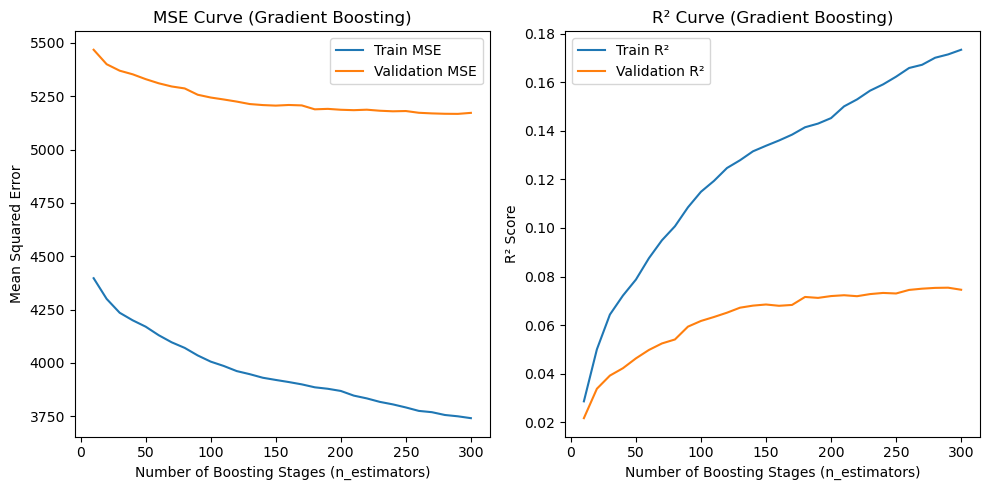

In [17]:
#Gradient boosting regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

train_errors = []
val_errors = []
train_r2_scores = []
val_r2_scores = []
n_estimators_range = range(10, 310, 10)  # Varying number of boosting stages from 10 to 100

best_r2 = -np.inf
best_n_estimators = 0
best_model = None

for n_estimators in n_estimators_range:
    # Initialize and train the model
    model = GradientBoostingRegressor(n_estimators=n_estimators, random_state=0)
    model.fit(X_train, y_train.ravel())
    
    # Predict on training and validation sets
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Calculate and store the errors (mean squared error)
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    val_errors.append(mean_squared_error(y_val, y_val_pred))
    
    # Calculate and store R² scores on training and validation sets
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)
    
    # Track the best model (based on validation R² score)
    if val_r2 > best_r2:
        best_r2 = val_r2
        best_n_estimators = n_estimators
        best_model = model

# Plot the MSE curve
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(n_estimators_range, train_errors, label="Train MSE")
plt.plot(n_estimators_range, val_errors, label="Validation MSE")
plt.title('MSE Curve (Gradient Boosting)')
plt.xlabel('Number of Boosting Stages (n_estimators)')
plt.ylabel('Mean Squared Error')
plt.legend()

# Plot the R² curve
plt.subplot(1, 2, 2)
plt.plot(n_estimators_range, train_r2_scores, label="Train R²")
plt.plot(n_estimators_range, val_r2_scores, label="Validation R²")
plt.title('R² Curve (Gradient Boosting)')
plt.xlabel('Number of Boosting Stages (n_estimators)')
plt.ylabel('R² Score')
plt.legend()

plt.tight_layout()
#plt.show()
plt.savefig("whole_blood_gradient_boosting_regression.png", dpi=300)

# Print the R² score of the best model
print(f'The best number of boosting stages is: {best_n_estimators}')
print(f'R² Score of the best model: {best_r2:.2f}')

In [6]:
#For cerebellum dataset
data = pd.read_csv("intersect_4DNFIWCAQUIK.10kb.with_id.with_transcripts.erna_gene_filt.with_exp.txt", sep = "\t")

In [7]:
data

,transcript1,expression1,transcript2,expression2,dist,norm_contacts
0,ENSG00000189339,-0.139152,ENSR00000249824,-0.218757,250000,1
1,ENSG00000008128,-0.007803,ENSR00000249824,-0.218757,220000,5
2,ENSR00000249824,-0.218757,ENSR00000249824,-0.218757,0,148
3,ENSG00000215915,0.020419,ENSR00000249824,-0.218757,480000,1
4,ENSG00000231050,-0.063613,ENSR00000249824,-0.218757,40000,1
...,...,...,...,...,...,...
95696,ENSG00000008735,-0.006373,ENSR00000147753,0.005671,50000,2
95697,ENSG00000100412,0.023097,ENSR00000147753,0.005671,9160000,1
95698,ENSR00000147753,0.005671,ENSG00000079974,-0.007761,110000,1
95699,ENSR00000143576,-0.130605,ENSG00000079974,-0.007761,32990000,1


In [8]:
#Prepare training, validation, and test data
train = data[["expression1", "expression2", "dist", "norm_contacts"]]
train_features = train.copy()

##Log-normalize contact frequencies
#train_features["norm_contacts"] = np.log(train_features["norm_contacts"])

##Log1p-normalize genomic distances
#train_features["dist"] = np.log1p(train_features["dist"])

train_labels = train_features.pop("norm_contacts")
#train_features.pop("expression1")
#train_features.pop("expression2")
train_features.pop("dist")
train_labels

#train_labels = list(map(lambda x: x.replace('ad', '0'), train_labels))
#train_labels = list(map(lambda x: x.replace('scc', '1'), train_labels))

#train_labels = [int(x) for x in train_labels]
train_labels = np.array(train_labels)

train_labels

train_set_final, test_set_final, train_labels_final, test_labels_final = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)
#val_set_final, test_set_final, val_labels_final, test_labels_final = train_test_split(test_set_prelim, test_labels_prelim, test_size=0.5, random_state=42)

In [9]:
train_set_final = np.array(train_set_final)
train_set_final.shape

train_labels_final = np.array(train_labels_final)
train_labels_final.shape

(76560,)

In [10]:
test_set_final = np.array(test_set_final)
test_set_final.shape

(19141, 2)

In [11]:
train_features = np.array(train_features)

In [12]:
# X = np.concatenate((train_set_final, val_set_final), axis=0)
# y = np.concatenate((train_labels_final, val_labels_final), axis=0)
X = train_set_final
y = train_labels_final

In [13]:
#Initialize a linear regression model and fit it to the training set
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [14]:
#Test the model using the test set
y_pred = model.predict(test_set_final)

In [15]:
#Calculare the predictive R2 of the model
r2 = r2_score(test_labels_final, y_pred)
print(f'R² Score: {r2:.5f}')

R² Score: 0.00003


The best polynomial degree is: 8
R² Score of the best model: 0.08


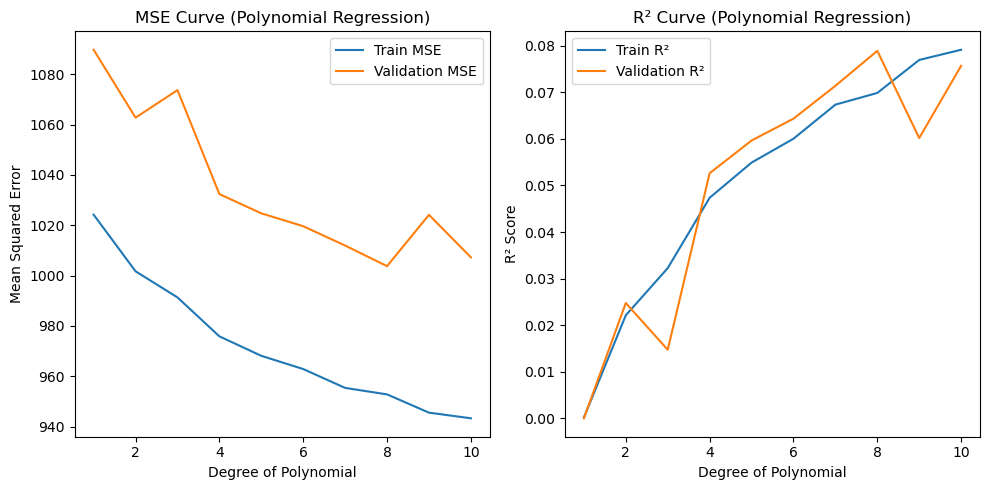

In [28]:
#Polynomial regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

train_errors = []
val_errors = []
val_r2_scores = []
train_r2_scores = []
degrees = range(1, 11)  # Trying polynomial degrees from 1 to 10

best_r2 = -np.inf
best_degree = 0
best_model = None

for degree in degrees:
    # Transform features into polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X_train)
    X_poly_val = poly.transform(X_val)
    
    # Train the model
    model = LinearRegression()
    model.fit(X_poly_train, y_train)
    
    # Predict on training and validation sets
    y_train_pred = model.predict(X_poly_train)
    y_val_pred = model.predict(X_poly_val)
    
    # Calculate and store the errors (mean squared error)
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    val_errors.append(mean_squared_error(y_val, y_val_pred))
    
    # Calculate and store R² scores on training and validation sets
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)
    
    # Track the best model (based on validation R² score)
    if val_r2 > best_r2:
        best_r2 = val_r2
        best_degree = degree
        best_model = model

# Plot the MSE curve
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(degrees, train_errors, label="Train MSE")
plt.plot(degrees, val_errors, label="Validation MSE")
plt.title('MSE Curve (Polynomial Regression)')
plt.xlabel('Degree of Polynomial')
plt.ylabel('Mean Squared Error')
plt.legend()

# Plot the R² curve
plt.subplot(1, 2, 2)
plt.plot(degrees, train_r2_scores, label="Train R²")
plt.plot(degrees, val_r2_scores, label="Validation R²")
plt.title('R² Curve (Polynomial Regression)')
plt.xlabel('Degree of Polynomial')
plt.ylabel('R² Score')
plt.legend()

plt.tight_layout()
#plt.show()
plt.savefig("cerebellum_polynomial_regression.png", dpi=300)

# Print the R² score of the best model
print(f'The best polynomial degree is: {best_degree}')
print(f'R² Score of the best model: {best_r2:.2f}')

The best number of trees is: 100
R² Score of the best model: 0.13


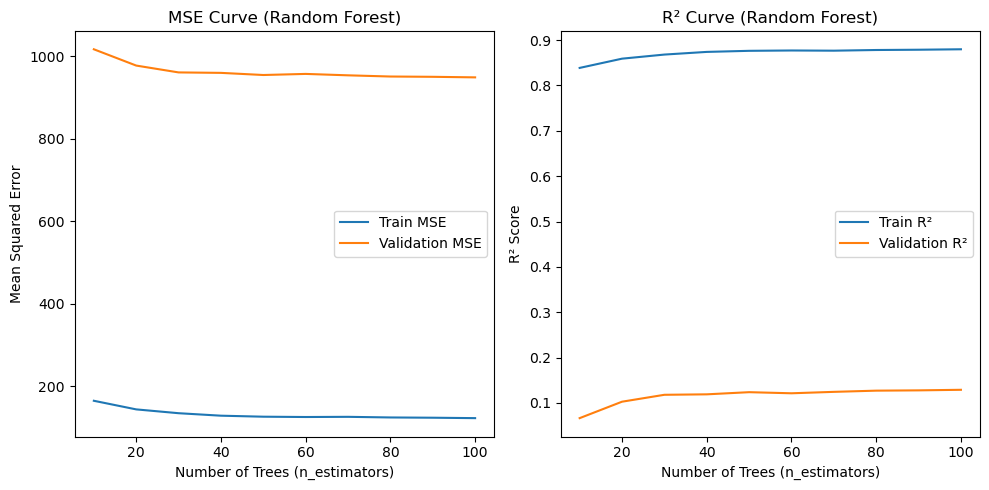

In [29]:
#Random forest regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

train_errors = []
val_errors = []
train_r2_scores = []
val_r2_scores = []
n_estimators_range = range(10, 110, 10)  # Varying number of trees from 10 to 100

best_r2 = -np.inf
best_n_estimators = 0
best_model = None

for n_estimators in n_estimators_range:
    # Initialize and train the model
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=0)
    model.fit(X_train, y_train.ravel())
    
    # Predict on training and validation sets
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Calculate and store the errors (mean squared error)
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    val_errors.append(mean_squared_error(y_val, y_val_pred))
    
    # Calculate and store R² scores on training and validation sets
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)
    
    # Track the best model (based on validation R² score)
    if val_r2 > best_r2:
        best_r2 = val_r2
        best_n_estimators = n_estimators
        best_model = model

# Plot the MSE curve
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(n_estimators_range, train_errors, label="Train MSE")
plt.plot(n_estimators_range, val_errors, label="Validation MSE")
plt.title('MSE Curve (Random Forest)')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Mean Squared Error')
plt.legend()

# Plot the R² curve
plt.subplot(1, 2, 2)
plt.plot(n_estimators_range, train_r2_scores, label="Train R²")
plt.plot(n_estimators_range, val_r2_scores, label="Validation R²")
plt.title('R² Curve (Random Forest)')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('R² Score')
plt.legend()

plt.tight_layout()
#plt.show()
plt.savefig("cerebellum_random_forest_regression.png", dpi=300)

# Print the R² score of the best model
print(f'The best number of trees is: {best_n_estimators}')
print(f'R² Score of the best model: {best_r2:.2f}')

The best epsilon is: 3.7
R² Score of the best model: 0.01


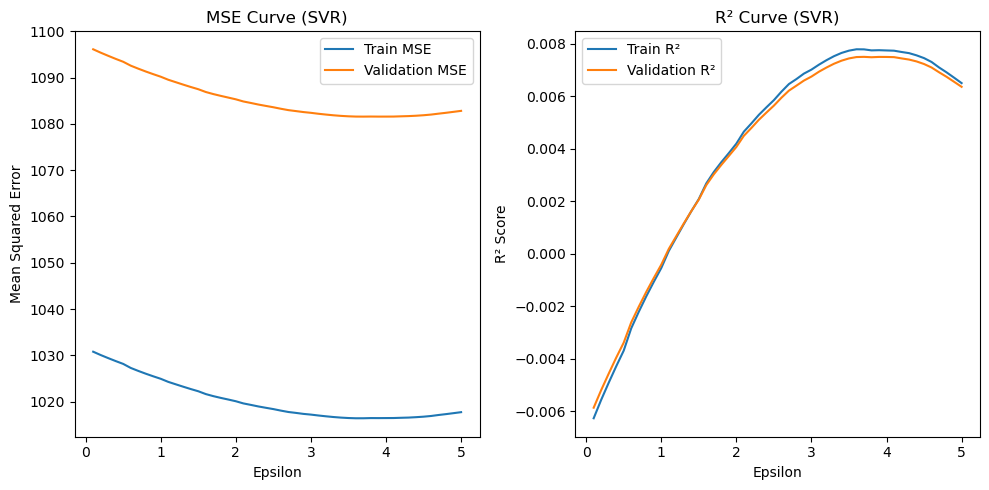

In [16]:
#Support vector regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

train_errors = []
val_errors = []
train_r2_scores = []
val_r2_scores = []
epsilon_range = np.arange(0.1, 5.1, 0.1)  # Varying epsilon from 0.1 to 5.0

best_r2 = -np.inf
best_epsilon = 0
best_model = None

for epsilon in epsilon_range:
    # Initialize and train the model
    model = SVR(kernel='rbf', C=1.0, epsilon=epsilon)
    model.fit(X_train, y_train.ravel())
    
    # Predict on training and validation sets
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Calculate and store the errors (mean squared error)
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    val_errors.append(mean_squared_error(y_val, y_val_pred))
    
    # Calculate and store R² scores on training and validation sets
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)
    
    # Track the best model (based on validation R² score)
    if val_r2 > best_r2:
        best_r2 = val_r2
        best_epsilon = epsilon
        best_model = model

# Plot the MSE curve
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epsilon_range, train_errors, label="Train MSE")
plt.plot(epsilon_range, val_errors, label="Validation MSE")
plt.title('MSE Curve (SVR)')
plt.xlabel('Epsilon')
plt.ylabel('Mean Squared Error')
plt.legend()

# Plot the R² curve
plt.subplot(1, 2, 2)
plt.plot(epsilon_range, train_r2_scores, label="Train R²")
plt.plot(epsilon_range, val_r2_scores, label="Validation R²")
plt.title('R² Curve (SVR)')
plt.xlabel('Epsilon')
plt.ylabel('R² Score')
plt.legend()

plt.tight_layout()
#plt.show()
plt.savefig("cerebellum_support_vector_regression.png", dpi=300)

# Print the R² score of the best model
print(f'The best epsilon is: {best_epsilon}')
print(f'R² Score of the best model: {best_r2:.2f}')

The best number of boosting stages is: 290
R² Score of the best model: 0.13


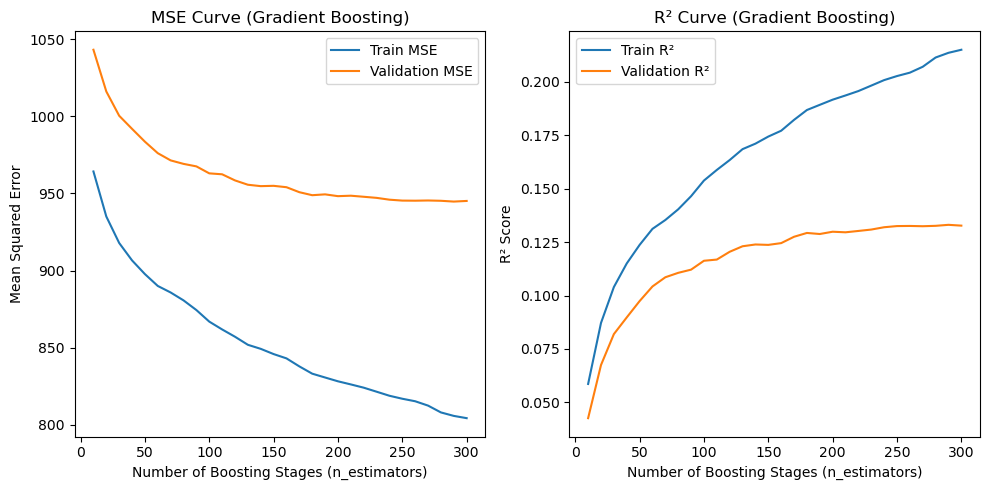

In [31]:
#Gradient boosting regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

train_errors = []
val_errors = []
train_r2_scores = []
val_r2_scores = []
n_estimators_range = range(10, 310, 10)  # Varying number of boosting stages from 10 to 100

best_r2 = -np.inf
best_n_estimators = 0
best_model = None

for n_estimators in n_estimators_range:
    # Initialize and train the model
    model = GradientBoostingRegressor(n_estimators=n_estimators, random_state=0)
    model.fit(X_train, y_train.ravel())
    
    # Predict on training and validation sets
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Calculate and store the errors (mean squared error)
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    val_errors.append(mean_squared_error(y_val, y_val_pred))
    
    # Calculate and store R² scores on training and validation sets
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)
    
    # Track the best model (based on validation R² score)
    if val_r2 > best_r2:
        best_r2 = val_r2
        best_n_estimators = n_estimators
        best_model = model

# Plot the MSE curve
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(n_estimators_range, train_errors, label="Train MSE")
plt.plot(n_estimators_range, val_errors, label="Validation MSE")
plt.title('MSE Curve (Gradient Boosting)')
plt.xlabel('Number of Boosting Stages (n_estimators)')
plt.ylabel('Mean Squared Error')
plt.legend()

# Plot the R² curve
plt.subplot(1, 2, 2)
plt.plot(n_estimators_range, train_r2_scores, label="Train R²")
plt.plot(n_estimators_range, val_r2_scores, label="Validation R²")
plt.title('R² Curve (Gradient Boosting)')
plt.xlabel('Number of Boosting Stages (n_estimators)')
plt.ylabel('R² Score')
plt.legend()

plt.tight_layout()
#plt.show()
plt.savefig("cerebellum_gradient_boosting_regression.png", dpi=300)

# Print the R² score of the best model
print(f'The best number of boosting stages is: {best_n_estimators}')
print(f'R² Score of the best model: {best_r2:.2f}')